# Stroke Prediction - Modeling

## Capstone Project 1 - Brooke Hanson

### Introduction

### 1: The Problem 

This data was recorded in order for hospitals and healthcare practitioners to better understand the factors that most influence stroke occurance. The goal is to create a predictive model that will determine whether or not new patients will experience a stroke. This is a classification problem.

### 2: The Data

The Kaggle hosts the original problem and the dataset in their website as one of their competitions. Here, I downloaded the data from the Kaggle website. Following are the data fields in the dataset, which we are going to read in the Pandas data frame.

- id 
- gender             
- age                
- hypertension         
- heart_disease        
- ever_married        
- work_type           
- Residence_type     
- avg_glucose_level  
- bmi                
- smoking_status      
- stroke

### Importing Necessary Packages & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency as chi2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.preprocessing import scale

In [6]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# filling NA in BMI
# df['bmi'] = df['bmi'].replace(np.nan ,np.median(df['bmi'])) 
median_value = 28.1 # can see from info table that the median for bmi is 28.1
df['bmi'].fillna(value=median_value, inplace=True)

In [8]:
df['gender'] = df['gender'].replace('Other', 'Female')

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,5110.0,28.862035,7.699562,10.30,23.800,28.100,32.80,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


### Testing and Making Model

Here I am replacing the values of 0 and 1 with Yes and No since these are categorical representations and will work better

In [10]:
df['hypertension'] = df['hypertension'].replace({0 : 'No', 1 : 'Yes'})
df['heart_disease'] = df['heart_disease'].replace({0: 'No', 1 : 'Yes'})
df = df[['age', 'hypertension','heart_disease', 'avg_glucose_level','bmi','stroke','gender','ever_married','work_type','Residence_type','smoking_status']]

#### Making Dummy Variables

In [11]:
df1 = pd.get_dummies(df, drop_first = True) 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   avg_glucose_level               5110 non-null   float64
 2   bmi                             5110 non-null   float64
 3   stroke                          5110 non-null   int64  
 4   hypertension_Yes                5110 non-null   uint8  
 5   heart_disease_Yes               5110 non-null   uint8  
 6   gender_Male                     5110 non-null   uint8  
 7   ever_married_Yes                5110 non-null   uint8  
 8   work_type_Never_worked          5110 non-null   uint8  
 9   work_type_Private               5110 non-null   uint8  
 10  work_type_Self-employed         5110 non-null   uint8  
 11  work_type_children              5110 non-null   uint8  
 12  Residence_type_Urban            51

### Testing best Split size

In [12]:
X = df1.drop('stroke', axis = 1)
y = df1.stroke

In [15]:
import math
from sklearn.ensemble import RandomForestClassifier

Before running the models I wanted to observe effect the differences in test size has for both precision and recall

In [16]:
size = [0.001, 0.01, 0.1, 0.3, 0.33, 0.35]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
for i in size:
    # fit the model
    model = RandomForestClassifier(random_state=1)
    #changed size of training sets
    model.fit(X_train.iloc[0:math.floor(i*X_train.shape[0])], y_train.iloc[0:math.floor(i*y_train.shape[0])])
    # make predictions
    y_pred = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy: %.3f' % acc)

Accuracy: 0.941
Accuracy: 0.938
Accuracy: 0.941
Accuracy: 0.940
Accuracy: 0.940
Accuracy: 0.941


In [17]:
size = [0.001, 0.01, 0.1, 0.3, 0.33, 0.35]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
for i in size:
    # fit the model
    model = RandomForestClassifier(random_state=1)
    #changed size of training sets
    model.fit(X_train.iloc[0:math.floor(i*X_train.shape[0])], y_train.iloc[0:math.floor(i*y_train.shape[0])])
    # make predictions
    y_pred = model.predict(X_test)
    # evaluate predictions
    acc = recall_score(y_test, y_pred)
    print('Recall: %.3f' % acc)

Recall: 0.000
Recall: 0.033
Recall: 0.017
Recall: 0.000
Recall: 0.000
Recall: 0.000


In [18]:
X_train.shape[0]

4088

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [20]:
X_train.shape, y_train.shape

((4599, 15), (4599,))

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 346 to 860
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4599 non-null   float64
 1   avg_glucose_level               4599 non-null   float64
 2   bmi                             4599 non-null   float64
 3   hypertension_Yes                4599 non-null   uint8  
 4   heart_disease_Yes               4599 non-null   uint8  
 5   gender_Male                     4599 non-null   uint8  
 6   ever_married_Yes                4599 non-null   uint8  
 7   work_type_Never_worked          4599 non-null   uint8  
 8   work_type_Private               4599 non-null   uint8  
 9   work_type_Self-employed         4599 non-null   uint8  
 10  work_type_children              4599 non-null   uint8  
 11  Residence_type_Urban            4599 non-null   uint8  
 12  smoking_status_formerly smoked  4

Because this is a classification problem I started model selection by looking at a basic Decision Tree Model

### Decision Tree Model

In [22]:
clf = DecisionTreeClassifier(class_weight = 'balanced',random_state=0)
clf.fit(X_train ,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [23]:
y_pred = clf.predict(X_test)

In [24]:
confusion_matrix(y_pred, y_test)

array([[464,  27],
       [ 19,   1]])

From this confusion matrix we can see that the decision tree model is more effective at identifying true positives opposed to true negatives. This may be a problem to address as the model's purpose is to better predict stroke occurance therefor false negatives can be dangerous.

In [25]:
list(zip(clf.feature_importances_,X_test.columns))

[(0.4463323129200995, 'age'),
 (0.2229252678575099, 'avg_glucose_level'),
 (0.16679252610196643, 'bmi'),
 (0.024725569847581837, 'hypertension_Yes'),
 (0.020822312031021875, 'heart_disease_Yes'),
 (0.02128329584366639, 'gender_Male'),
 (0.01886342615089682, 'ever_married_Yes'),
 (0.0, 'work_type_Never_worked'),
 (0.01606889440903949, 'work_type_Private'),
 (0.016290247595345614, 'work_type_Self-employed'),
 (0.0, 'work_type_children'),
 (0.006415820967935133, 'Residence_type_Urban'),
 (0.019046690431450936, 'smoking_status_formerly smoked'),
 (0.010483116744207927, 'smoking_status_never smoked'),
 (0.009950519099278275, 'smoking_status_smokes')]

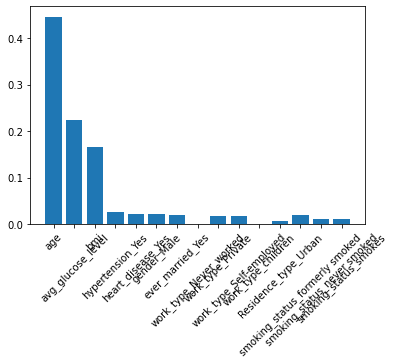

In [26]:
importance = clf.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14], labels = X_test.columns, rotation = 45)
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

In [27]:
cv_scores_test= cross_val_score(clf,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(clf,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_dt_test= cv_scores_test.mean()
cv_scores_dt_train= cv_scores_train.mean()
cv_scores_std_dt= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_dt_test))
print ('Mean cross validation train score: ' +str(cv_scores_dt_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_dt))

[0.16666667 0.2        0.2        0.         0.16666667]
Mean cross validation test score: 0.14666666666666667
Mean cross validation train score: 0.12222222222222223
Standard deviation in cv scores: 0.07483314773547883


In [28]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_dt=clf.score(X_test,y_test)
rc_dt = recall_score(y_test, y_pred, average = 'weighted')
print('Random Forest: Accuracy =%.3f' % (Accuracy_dt))
print('Random Forest: Recall=%.3f' % (rc_dt))

[[464  19]
 [ 27   1]]
Random Forest: Accuracy =0.910
Random Forest: Recall=0.910


In [29]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred, average = 'weighted')

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.05


It seems the Decision Tree model was a good place to start but not necessarily the best predictive model with accuracy and recall scores of 0.91

### K Nearest Neighbor

In [31]:
# normalize any other non categorical variables, can standardize by max and min
# look at hyper parameters in grid search
# see performance decrease with overfitting
# for each model i chose find optimal hyperparameter
# and explain meaning of hyperparameter i chose but not too many 
# for decision start with max depth
# for random forest do 20 50 80 scale for optimizing

# not scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

print(nca_pipe.score(X_test, y_test))

0.9295499021526419


In [32]:
y_pred = knn.predict(X_test)

In [33]:
print("Recall Score: %f%%" %  recall_score(y_test,y_pred, average='weighted'))

Recall Score: 0.939335%


In [34]:
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(Xs_train, y_train)

print(nca_pipe.score(Xs_test, y_test))

0.9334637964774951


In [35]:
y_pred_s = knn.predict(Xs_test)
print("Recall Score: %f%%" % recall_score(y_test,y_pred, average = 'weighted'))

Recall Score: 0.939335%


We see here that the Recall Score for the scaled data was comperablethan the recall with the unscaled data

In [36]:
from sklearn.model_selection import cross_val_score
#unscaled train test
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.07692308 0.15384615 0.08333333 0.41666667 0.08333333]
Mean cross validation test score: 0.16282051282051285
Mean cross validation train score: 0.04836415362731152
Standard deviation in cv scores: 0.13002553736931385


In [120]:
#  Import 'r2_score'
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    #   Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    
    # Return the score
    return score

def acc_met (y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    acc = cnf_matrix[1,1]/cnf_matrix[1,0]
    return acc

# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_splits = 3, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = DecisionTreeClassifier()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(acc_met)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid 


reg = fit_model(X_train, y_train)

/Users/brookehanson/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass scoring=make_scorer(acc_met) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyboardInterrupt: 

In [41]:
#scaled train test
cv_scores_test= cross_val_score(knn,Xs_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(knn,Xs_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))

[0.         0.         0.08333333 0.         0.        ]
Mean cross validation test score: 0.016666666666666666
Mean cross validation train score: 0.053342816500711245
Standard deviation in cv scores: 0.03333333333333333


In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_knn=knn.score(X_test,y_test)
rc_knn = recall_score(y_test, y_pred, average = 'weighted')
print('Random Forest: Accuracy =%.3f' % (Accuracy_knn))
print('Random Forest: Recall=%.3f' % (rc_knn))

In [44]:
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.06


### Random Forrest

In [46]:
# recall
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1, class_weight = 'balanced')
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
rc_rf = recall_score(y_test, y_pred, average = 'weighted')

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Recall=%.3f' % (rc_rf))

print('Random Forest: f1-score=%.3f' % (f1))

print(cm)

Random Forest: Recall=0.939
Random Forest: f1-score=0.910
[[960   0]
 [ 62   0]]


In [47]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_rf=clf.score(X_test,y_test)
print('Random Forest: Accuracy =%.3f' % (Accuracy_rf))
print('Random Forest: Recall=%.3f' % (rc_rf))

[[960   0]
 [ 62   0]]
Random Forest: Accuracy =0.939
Random Forest: Recall=0.939


The confusion matrix shows us that the basic random forrest model is not ideal without hyperparameters. 

In [48]:
list(zip(clf.feature_importances_,X_test.columns))
#X_test.shape

[(0.3829666155002953, 'age'),
 (0.20033151459028062, 'avg_glucose_level'),
 (0.1782142329175987, 'bmi'),
 (0.030787679375937523, 'hypertension_Yes'),
 (0.024483446036926777, 'heart_disease_Yes'),
 (0.024686757645407027, 'gender_Male'),
 (0.030160805517408323, 'ever_married_Yes'),
 (0.00013516552050641021, 'work_type_Never_worked'),
 (0.019976143333629542, 'work_type_Private'),
 (0.018120747029999267, 'work_type_Self-employed'),
 (0.012634883322554778, 'work_type_children'),
 (0.024906969175332357, 'Residence_type_Urban'),
 (0.016442404192773298, 'smoking_status_formerly smoked'),
 (0.01930696612657982, 'smoking_status_never smoked'),
 (0.01684566971477039, 'smoking_status_smokes')]

age : 0, Score: 0.38297
avg_glucose_level : 1, Score: 0.20033
bmi : 2, Score: 0.17821
hypertension_Yes : 3, Score: 0.03079
heart_disease_Yes : 4, Score: 0.02448
gender_Male : 5, Score: 0.02469
ever_married_Yes : 6, Score: 0.03016
work_type_Never_worked : 7, Score: 0.00014
work_type_Private : 8, Score: 0.01998
work_type_Self-employed : 9, Score: 0.01812
work_type_children : 10, Score: 0.01263
Residence_type_Urban : 11, Score: 0.02491
smoking_status_formerly smoked : 12, Score: 0.01644
smoking_status_never smoked : 13, Score: 0.01931
smoking_status_smokes : 14, Score: 0.01685


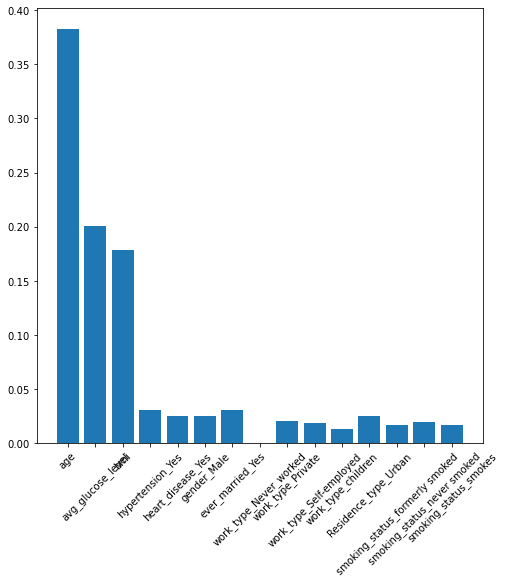

In [49]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_test.columns[i],': %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14], labels = X_test.columns, rotation = 45)
plt.rcParams["figure.figsize"] = (8,8)
pyplot.show()

In [50]:
cv_scores_test= cross_val_score(clf,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(clf,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0. 0. 0. 0. 0.]
Mean cross validation test score: 0.0
Mean cross validation train score: 0.005263157894736842
Standard deviation in cv scores: 0.0


### Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score

In [53]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1022 points : 464


In [54]:
#scaled data
y_pred = gnb.fit(Xs_train, y_train).predict(Xs_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (Xs_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1022 points : 717


In [58]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
Accuracy_nb=gnb.score(X_test,y_test)
rc_nb = recall_score(y_test, y_pred, average = 'weighted')
print('Random Forest: Accuracy=%.3f' % (Accuracy_nb))
print('Random Forest: Recall=%.3f' % (rc_nb))

[[243 717]
 [  0  62]]
Random Forest: Accuracy=0.939
Random Forest: Recall=0.298


In [59]:
def acc_met (y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    acc = cnf_matrix[1,1]/cnf_matrix[1,0]
    return acc

In [60]:
acc_met(y_test,y_pred)

<ipython-input-59-fcc04af75542>:3: RuntimeWarning: divide by zero encountered in long_scalars
  acc = cnf_matrix[1,1]/cnf_matrix[1,0]


inf

In [61]:
cnf_matrix

array([[243, 717],
       [  0,  62]])

In [62]:
# unscaled data
cv_scores_test= cross_val_score(gnb,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(gnb,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.92307692 1.         1.         1.         1.        ]
Mean cross validation test score: 0.9846153846153847
Mean cross validation train score: 0.8982930298719772
Standard deviation in cv scores: 0.03076923076923075


In [63]:
#scaled data
cv_scores_test= cross_val_score(gnb,Xs_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(gnb,Xs_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[1. 1. 1. 1. 1.]
Mean cross validation test score: 1.0
Mean cross validation train score: 0.9893314366998578
Standard deviation in cv scores: 0.0


### Gradient Boosting Model

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

In [87]:
gbc = GradientBoostingClassifier(n_estimators=300, random_state = 1)
model_res = gbc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
rc_gbc = recall_score(y_test, y_pred, average = 'weighted')

In [94]:
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
Accuracy_gbc=gbc.score(X_test,y_test)

print('Random Forest: Recall=%.3f' % (rc_gbc))

print('Random Forest: f1-score=%.3f' % (f1))

print(cm)

Random Forest: Recall=0.940
Random Forest: f1-score=0.917
[[957   3]
 [ 58   4]]


In [90]:
list(zip(gbc.feature_importances_,X_test.columns))

[(0.29877667136562697, 'age'),
 (0.42190338855182263, 'avg_glucose_level'),
 (0.16142871437116668, 'bmi'),
 (0.026034295200296917, 'hypertension_Yes'),
 (0.021426472698501082, 'heart_disease_Yes'),
 (0.004207404538240232, 'gender_Male'),
 (0.014571981997254638, 'ever_married_Yes'),
 (0.0, 'work_type_Never_worked'),
 (0.009216265635523052, 'work_type_Private'),
 (0.009566605524093257, 'work_type_Self-employed'),
 (0.0008863254070479488, 'work_type_children'),
 (0.0037435551124264496, 'Residence_type_Urban'),
 (0.00715582643136899, 'smoking_status_formerly smoked'),
 (0.015619218013739222, 'smoking_status_never smoked'),
 (0.005463275152891761, 'smoking_status_smokes')]

age : 0, Score: 0.29878
avg_glucose_level : 1, Score: 0.42190
bmi : 2, Score: 0.16143
hypertension_Yes : 3, Score: 0.02603
heart_disease_Yes : 4, Score: 0.02143
gender_Male : 5, Score: 0.00421
ever_married_Yes : 6, Score: 0.01457
work_type_Never_worked : 7, Score: 0.00000
work_type_Private : 8, Score: 0.00922
work_type_Self-employed : 9, Score: 0.00957
work_type_children : 10, Score: 0.00089
Residence_type_Urban : 11, Score: 0.00374
smoking_status_formerly smoked : 12, Score: 0.00716
smoking_status_never smoked : 13, Score: 0.01562
smoking_status_smokes : 14, Score: 0.00546


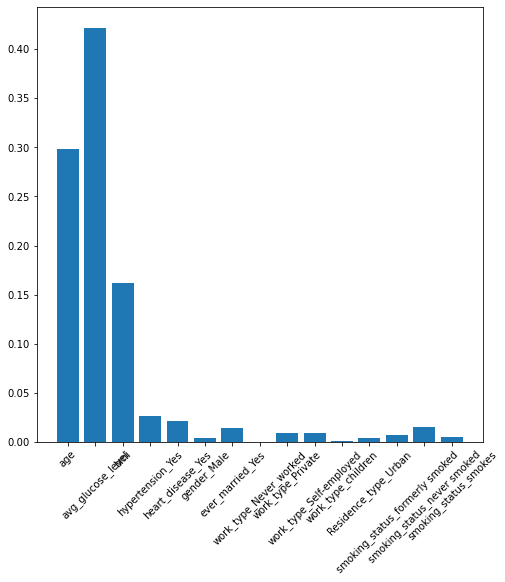

In [91]:
importance = gbc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(X_test.columns[i],': %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14], labels = X_test.columns, rotation = 45)
plt.rcParams["figure.figsize"] = (8,8)
pyplot.show()

In [93]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.         0.15384615 0.08333333 0.25       0.08333333]
Mean cross validation test score: 0.1141025641025641
Mean cross validation train score: 0.021479374110953058
Standard deviation in cv scores: 0.08361884030318117


In [130]:
#  Import 'r2_score'
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    #   Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    
    # Return the score
    return score

def acc_met (y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    acc = cnf_matrix[1,1]/cnf_matrix[1,0]
    return acc

# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV





In [133]:
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_splits = 3, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = GradientBoostingClassifier()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {"loss":["deviance"],
    "learning_rate": [0.05],
    "max_depth":[3,5,8],
    "criterion": [ "mae"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10,40, 100]}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(acc_met)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid 


In [ ]:
reg = fit_model(X_train, y_train)

### Model Comparison

In [95]:
#plot grid search, only use 2 hyperparameters
myLabels = [ 'Decision Tree','KNN','Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier']
score_test= [ cv_scores_dt_test, cv_scores_knn_test,cv_scores_rf_test,cv_scores_nb_test, cv_scores_gbc_test]
score_train= [  cv_scores_dt_train,cv_scores_knn_train,cv_scores_rf_train,cv_scores_nb_train, cv_scores_gbc_train]
Accuracy_score = [Accuracy_dt,Accuracy_knn,Accuracy_rf,Accuracy_nb,Accuracy_gbc ]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

                      Algorithm  Model accuracy score
0                 Decision Tree              0.909980
1                           KNN              0.939335
2                 Random Forest              0.939335
3                   Naive Bayes              0.939335
4  Gradient Boosting Classifier              0.940313


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Decision Tree,0.122222,0.146667
1,KNN,0.053343,0.016667
2,Random Forest,0.850071,0.826923
3,Naive Bayes,0.989331,1.000000
4,Gradient Boosting Classifier,0.021479,0.114103


In [96]:
myLabels = [ 'Decision Tree','KNN','Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier']
score_test= [ cv_scores_dt_test, cv_scores_knn_test,cv_scores_rf_test,cv_scores_nb_test, cv_scores_gbc_test]
score_train= [  cv_scores_dt_train,cv_scores_knn_train,cv_scores_rf_train,cv_scores_nb_train, cv_scores_gbc_train]
Recall_score_l = [rc_dt,rc_knn,rc_rf,rc_nb, rc_gbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Recall_score_l)), 
               columns =['Algorithm', 'Model Recall score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

                      Algorithm  Model Recall score
0                 Decision Tree            0.909980
1                           KNN            0.939335
2                 Random Forest            0.939335
3                   Naive Bayes            0.298434
4  Gradient Boosting Classifier            0.940313


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Decision Tree,0.122222,0.146667
1,KNN,0.053343,0.016667
2,Random Forest,0.850071,0.826923
3,Naive Bayes,0.989331,1.000000
4,Gradient Boosting Classifier,0.021479,0.114103


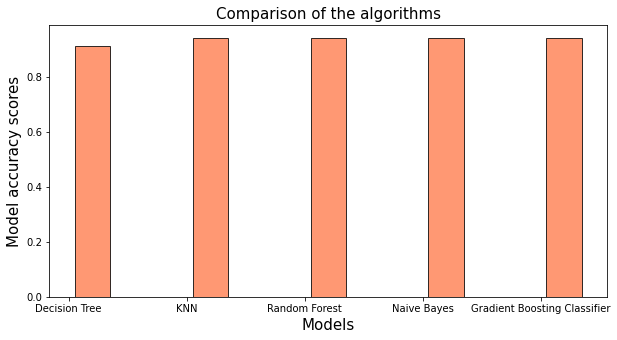

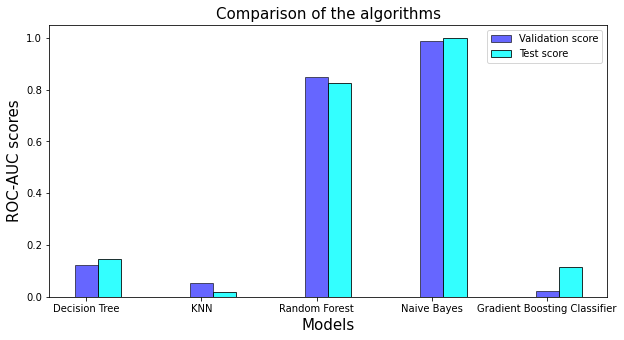

In [99]:
#plotting the accuracy scores:


index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4,5], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Validation score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4,5], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

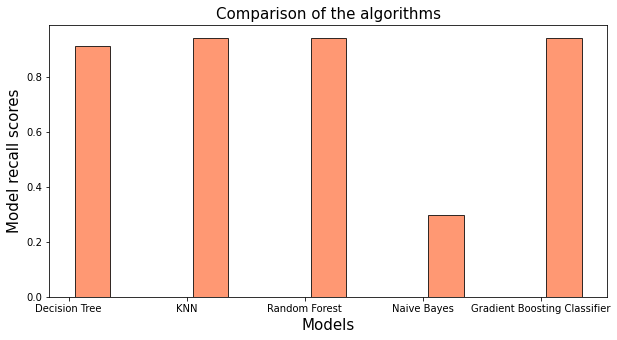

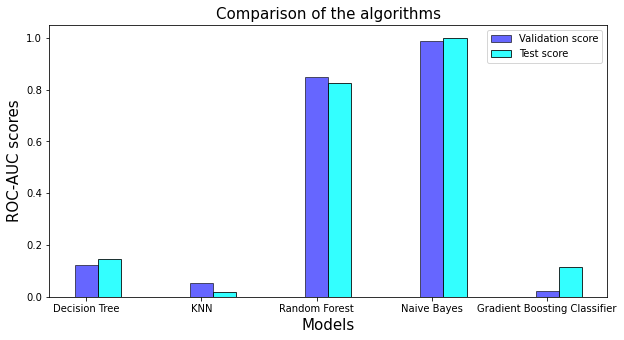

In [100]:
#plotting the Recall scores:


index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model recall scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Recall_score_l,color='coral',alpha=0.8,label='Recall score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4,5], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()

#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Validation score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4,5], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

In [101]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "max_depth" : [ 2, 4, 6, 8, 10], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

gs.best_estimator_
gs.best_score_

0.0

In [69]:
gs.best_params_


{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}

In [70]:
RandomForestClassifier(criterion='gini', n_jobs=-1, max_depth = 2, n_estimators = 50, random_state=1)

RandomForestClassifier(max_depth=2, n_estimators=50, n_jobs=-1, random_state=1)

In [111]:
rf = RandomForestClassifier(criterion='gini', n_jobs=-1, class_weight = 'balanced' ,max_depth = 2, n_estimators = 50,random_state=1)
rf.fit(X_train, y_train)
y_predictions_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cv = cross_val_score(rf, X_test, y_test,scoring='recall').mean()
rc = recall_score(y_test, y_predictions_rf)
print('Random Forest: Recall=%.3f' % (rc))
print('Random Forest: Accurracy=%.3f' % (acc))
print('Random Forest: Cross Validation Score = ',(cv))

0.9403131115459883
0.826923076923077
0.8709677419354839
Random Forest: Recall=0.871
Random Forest: Accurracy=0.940
Random Forest: Cross Validation Score =  0.826923076923077


In [73]:
cnf_matrix = confusion_matrix(y_test, y_predictions_rf)
print(cnf_matrix)
rf_recall = recall_score(y_test,y_predictions_rf, average = 'weighted')
print(rf_recall)

[[668 292]
 [  8  54]]
0.7064579256360078


In [74]:
#Feature importances:

features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

                          Features  Importance scores
0                              age           0.000073
1                avg_glucose_level           0.000354
2                              bmi           0.001231
3                 hypertension_Yes           0.001292
4                heart_disease_Yes           0.001547
5                      gender_Male           0.001725
6                 ever_married_Yes           0.017522
7           work_type_Never_worked           0.032544
8                work_type_Private           0.038827
9          work_type_Self-employed           0.053755
10              work_type_children           0.074524
11            Residence_type_Urban           0.090793
12  smoking_status_formerly smoked           0.091050
13     smoking_status_never smoked           0.151810
14           smoking_status_smokes           0.442954


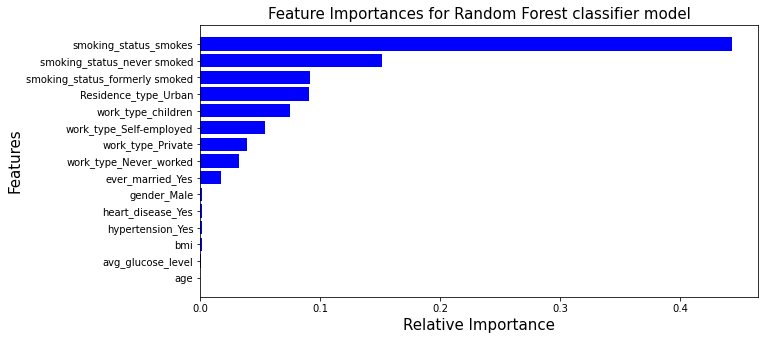

In [75]:
#Visual comparison:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.savefig("28.png")
plt.show()
#len(importances)
#create correlation matrix and see if they are highly correlated
# or make np.corr, or make model to see if age can be predicted by other facotrs, heatmap

In [76]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.854091061827957


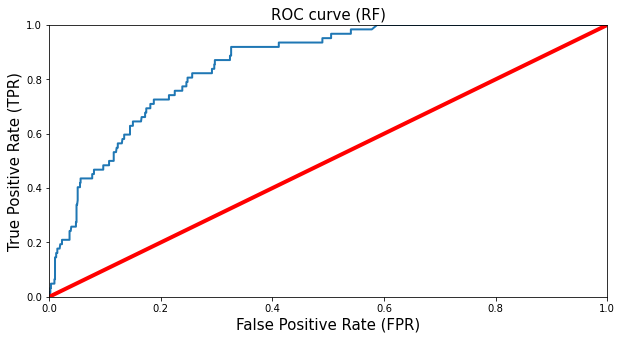

In [77]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

### Tune Gradient Boosting Classifier

In [104]:
gbc = GradientBoostingClassifier(max_features='auto',random_state=1)

#param_grid = { "criterion" : ["gini", "entropy"], "max_depth" : [ 2, 4, 6, 8, 10], "n_estimators": [50, 100,400,700,1000]}
param_grid = { "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.9, 1.0],
    "n_estimators":[10] }
gs = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)

gs = gs.fit(X_train, y_train)

gs.best_estimator_
gs.best_score_

0.1015531660692951

In [105]:
gs.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 10,
 'subsample': 0.5}

In [124]:
gbc = GradientBoostingClassifier(criterion = 'friedman_mse', learning_rate = 0.2, loss = 'deviance', max_depth = 8, max_features = 'log2', n_estimators = 10, subsample = 0.5)

In [125]:
gbc.fit(X_train, y_train)
y_predictions_gbc = gbc.predict(X_test)
acc_gbc = accuracy_score(y_test, y_pred)
cv_gbc = cross_val_score(gbc, X_test, y_test,scoring='recall').mean()
rc_gbc = recall_score(y_test, y_predictions_rf)
print('Random Forest: Recall=%.3f' % (rc_gbc))
print('Random Forest: Accurracy=%.3f' % (acc_gbc))
print('Random Forest: Cross Validation Score = ',(cv_gbc))


Random Forest: Recall=0.871
Random Forest: Accurracy=0.940
Random Forest: Cross Validation Score =  0.1141025641025641


In [126]:
confusion_matrix(y_test, y_pred)

array([[957,   3],
       [ 58,   4]])

In [116]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.07692308 0.07692308 0.25       0.33333333 0.16666667]
Mean cross validation test score: 0.1141025641025641
Mean cross validation train score: 0.021479374110953058
Standard deviation in cv scores: 0.08361884030318117


### Compare Tuned Random Forrest To Naive Bayes

In [78]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='recall')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='recall')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.84615385 0.53846154 0.83333333 0.91666667 1.        ]
Mean cross validation test score: 0.826923076923077
Mean cross validation train score: 0.8500711237553343
Standard deviation in cv scores: 0.15596827000764665


In [117]:
myLabels = [ 'Random Forest', 'Naive Bayes', 'Gradient Boosting Classifier']
score_test= [ cv_scores_rf_test,cv_scores_nb_test, cv_scores_gbc_test]
score_train= [  cv_scores_rf_train,cv_scores_nb_train, cv_scores_gbc_train]
recall_score_l2 = [rf_recall,rc_nb, rc_gbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, recall_score_l2)), 
               columns =['Algorithm', 'recall score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

                      Algorithm  recall score
0                 Random Forest      0.706458
1                   Naive Bayes      0.298434
2  Gradient Boosting Classifier      0.870968


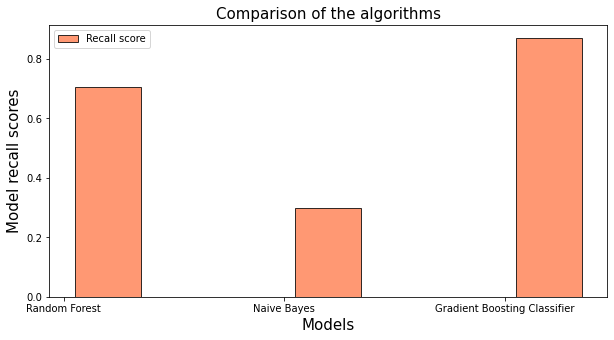

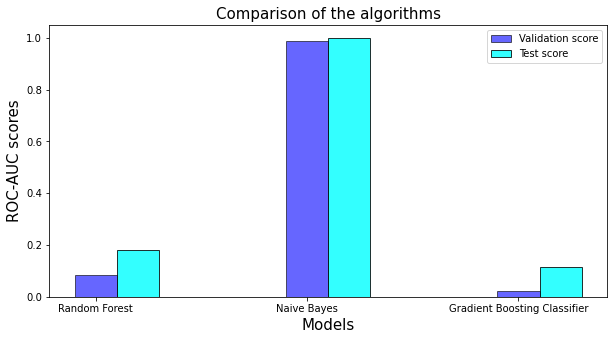

In [118]:
index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model recall scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
patterns = [ "/"]
_=plt.bar(index_acc,recall_score_l2,color='coral',alpha=0.8,label='Recall score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3], myLabels)
plt.legend()
plt.savefig("26.png")
plt.show()


index=[1,2,3]
index_acc=[1.2,2.2,3.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Validation score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

### Conclusions
In order to effectively predict stroke occurance, I looked at 14 features to most accurately predict, with the most important features being age, bmi, and avg glucose level.
This is a classification problem and used below models to identify accurate predictions
Random Forrest Classifier
Naive Bayes
Decision Tree
K-Nearest Neighbor
On initial testing it seemed Naive Bayes was the most accurate model, after tuning the Random Forrest model, I found their accurate prediction power was comperable.
The data was split into a test size of 0.30, and a training set of 0.7, this was decided by comparing accuracy of multiple test sizes finding 0.3 was the size that yielded best results.
After tuning the Random Forrest model, the model accuracy for both the Naive Bayes and Random Forrest both had scores of 0.939355


### Improvements
There is room for improvement in the data, there were 5110 patients yet there is room for more data. More classification algorithms could be used to compare and determine if there is a model with more predictive power. Some features with less importance could be removed to determine if that effects the predicting power.